In [7]:
# Importing Dependencies

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import glob
import xarray as xr
import warnings
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import rioxarray
from rasterio import features
from affine import Affine
import datetime

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pyhdf.SD import SD, SDC

plt.style.use('ggplot')

In [8]:
# Loading AOD DATASET FILE PATH

aod_file = glob.glob('./Data/AOD/*')

aod_insat3D = glob.glob(aod_file[0]+'/*')
aod_insat3DR = glob.glob(aod_file[1]+'/*')
aod_modis_dir = glob.glob(aod_file[2]+'/*')

aod_file

['./Data/AOD\\INSAT3D', './Data/AOD\\INSAT3DR', './Data/AOD\\MODIS_2018']

In [9]:
# MODIS DIR contain sub folder with no time dimension

# Create empty list to store file path with time stamp
aod_modis_path = []
time_stamp = []

# Mention Starting Year
start_year = np.datetime64('2018')

for path in aod_modis_dir:
    
    aod_modis_path.append(glob.glob(path+'/*'))
    day_no  = int(path.split('\\')[-1]) # Day number according to file name i,e 001,002,003,...365
    time_stamp.append(start_year + np.timedelta64(day_no-1, 'D')) # add timestamp to that particular file index

aod_modis_path[:5],time_stamp[:5]

([['./Data/AOD\\MODIS_2018\\001\\MOD08_D3.A2018001.061.2018003215357.hdf'],
  ['./Data/AOD\\MODIS_2018\\002\\MOD08_D3.A2018002.061.2018003215942.hdf'],
  ['./Data/AOD\\MODIS_2018\\003\\MOD08_D3.A2018003.061.2018004083950.hdf'],
  ['./Data/AOD\\MODIS_2018\\004\\MOD08_D3.A2018004.061.2018005083354.hdf'],
  ['./Data/AOD\\MODIS_2018\\005\\MOD08_D3.A2018005.061.2018008181118.hdf']],
 [numpy.datetime64('2018-01-01'),
  numpy.datetime64('2018-01-02'),
  numpy.datetime64('2018-01-03'),
  numpy.datetime64('2018-01-04'),
  numpy.datetime64('2018-01-05')])

In [10]:
# Declare Datafield Name
DATAFIELD_NAME = 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean'

# Temporary list to store data to make xarray dataset
DATA = []
TIME = []
LAT = []
LON = []

# Read MODIS file
for idx, FILE_NAME in  enumerate(aod_modis_path):
        
    hdf = SD(*FILE_NAME, SDC.READ)
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)
    
    # Read dataset.
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)

    # Read lat/lon.
    xdim = hdf.select('XDim')
    lon = xdim[:].astype(np.double)

    ydim = hdf.select('YDim')
    lat = ydim[:].astype(np.double)
    
    # Retrieve attributes.
    attrs = data_raw.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]

    # Fill 9999 with NaN value
    data[data == _FillValue] = np.nan
    data =  scale_factor * (data - add_offset) 
    datam = np.ma.masked_array(data, np.isnan(data))
    
    # Store result in DATA and TIME list
    TIME.append(time_stamp[idx])
    DATA.append(data)
    

# Make np array for list
TIME = np.array(TIME)
LAT = np.array(lat)
LON = np.array(lon)
DATA = np.array(DATA)

print("Data file is ready !!!")

Data file is ready !!!


In [11]:
# Read 3D and 3DR data 
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

# Create Modis Dataset
ds_modis = xr.Dataset(
        {
            'AOD': (['time','latitude', 'longitude'], DATA),
            'time': (['time'],TIME),
            'latitude': (['latitude'], LAT),
            'longitude': (['longitude'], LON),
        }
    )

# 1 Slicing
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,98)).load()
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,98)).load()
ds1_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))


In [12]:
# Merging Dataset
ds1_merged = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')
ds1_merged

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 310)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 97.75 97.85 97.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... 0.2794 nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

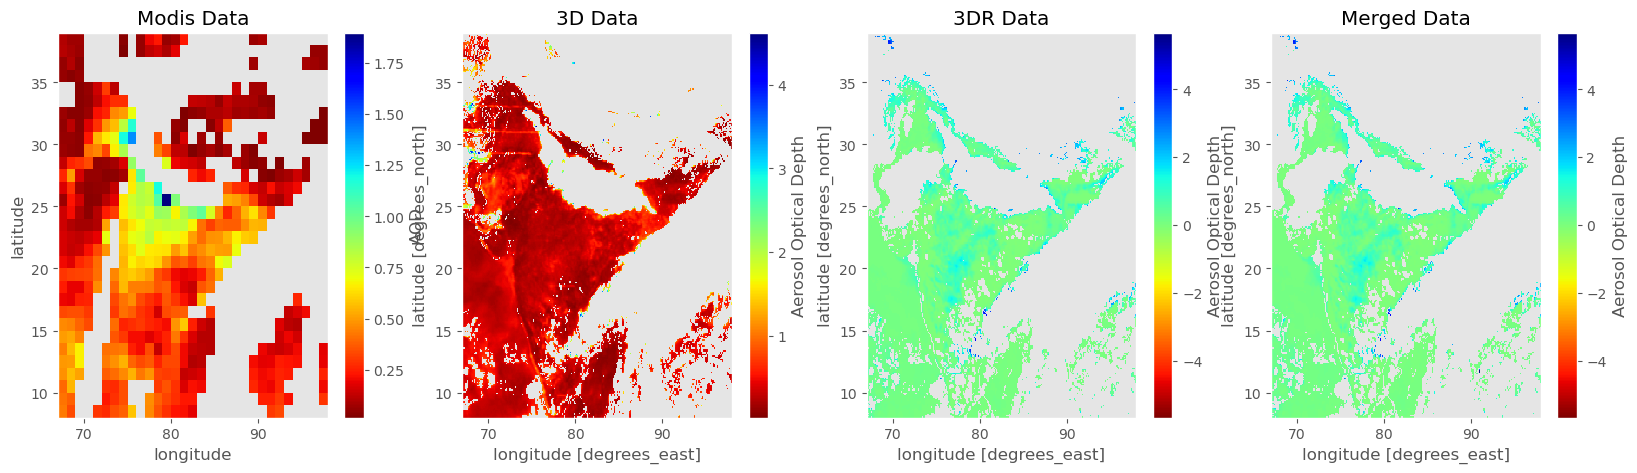

In [13]:
fig,ax = plt.subplots(ncols = 4, nrows = 1 , figsize=(20,5))
ds1_modis.AOD.isel(time=0).plot(ax=ax[0],cmap='jet_r')
ax[0].set_title('Modis Data')

ds1_3D.AOD.isel(time=0).plot(ax=ax[1],cmap='jet_r')
ax[1].set_title('3D Data')

ds1_3DR.AOD.isel(time=0).plot(ax=ax[2],cmap='jet_r')
ax[2].set_title('3DR Data')

ds1_merged.AOD.isel(time=0).plot(ax=ax[3],cmap='jet_r')
ax[3].set_title('Merged Data')

plt.show()

# Masking Dataset using shape file

In [14]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

In [15]:
def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))


In [16]:
def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [17]:
# Regridding 3D and 3DR data
def regrid(res,ds):
    
    # Output resolution
    out_res = float(res)

    # Half of orginal resolution
    interval_window = out_res/2 
    new_lat = np.arange(8-interval_window, 38 + out_res, out_res) # Latitude label i.e 8,..,38
    new_lon = np.arange(68-interval_window, 98 + out_res, out_res) # longitude Label i.e 68,..,98


    ds = ds.groupby_bins("longitude", bins=new_lon).mean(dim="longitude").groupby_bins("latitude", bins=new_lat).mean(dim="latitude")

   
    # Renaming longitude and latitude coordinate
    ds = ds.rename({"longitude_bins":"longitude","latitude_bins":"latitude"})

    ds['latitude'] = new_lat[:-1] + interval_window
    ds['longitude'] = new_lon[:-1] + interval_window
    
    ds1 = ds[['time','latitude','longitude','AOD']]
    
    return ds1

In [18]:
# Regridding
# ds2_3D = regrid(1,ds1_3D)
# ds2_3DR = regrid(1,ds1_3DR)

In [19]:
# 2 - Shape file dir
sf_dir = './Data/India_Boundary/India_Boundary.shp'

# ds_merged_mask = add_shape_coord_from_data_array(ds1_merged, sf_dir, "MASK")
# ds_merged_mask = ds_merged_mask.where(ds_merged_mask.MASK==0, other=np.nan)
# ds2_merged = ds_merged_mask.drop_vars('MASK')

ds_modis_mask = add_shape_coord_from_data_array(ds1_modis, sf_dir, "MASK")
ds_modis_mask = ds_modis_mask.where(ds_modis_mask.MASK==0, other=np.nan)
ds2_modis = ds_modis_mask.drop_vars('MASK')

ds_3D_mask = add_shape_coord_from_data_array(ds1_3D, sf_dir, "MASK")
ds_3D_mask = ds_3D_mask.where(ds_3D_mask.MASK==0, other=np.nan)
ds2_3D = ds_3D_mask.drop_vars('MASK')

ds_3DR_mask = add_shape_coord_from_data_array(ds1_3DR, sf_dir, "MASK")
ds_3DR_mask = ds_3DR_mask.where(ds_3DR_mask.MASK==0, other=np.nan)
ds2_3DR = ds_3DR_mask.drop_vars('MASK')

ds_merged_mask = add_shape_coord_from_data_array(ds1_merged, sf_dir, "MASK")
ds_merged_mask = ds_merged_mask.where(ds_3DR_mask.MASK==0, other=np.nan)
ds2_merged = ds_merged_mask.drop_vars('MASK')



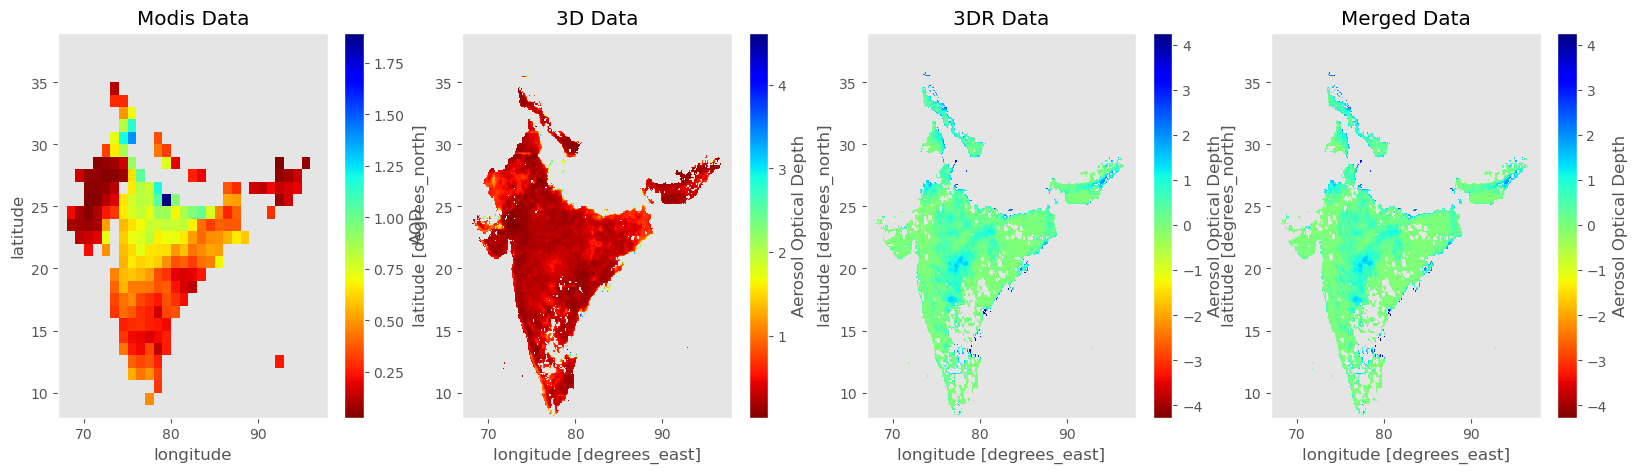

In [20]:
fig,ax = plt.subplots(ncols = 4, nrows = 1 , figsize=(20,5))
ds2_modis.AOD.isel(time=0).plot(ax=ax[0],cmap='jet_r')
ax[0].set_title('Modis Data')

ds2_3D.AOD.isel(time=0).plot(ax=ax[1],cmap='jet_r')
ax[1].set_title('3D Data')

ds2_3DR.AOD.isel(time=0).plot(ax=ax[2],cmap='jet_r')
ax[2].set_title('3DR Data')

ds2_merged.AOD.isel(time=0).plot(ax=ax[3],cmap='jet_r')
ax[3].set_title('Merged Data')

plt.show()

# Count Total Record per Day 

In [21]:
# Convert Hourly Time into Daily Time 
time_da = ds2_merged.time.dt.floor("1D")
df = pd.DataFrame(time_da,columns=['Day'])

x = df.Day.unique()
freq = df.Day.value_counts().sort_index()
data = {'Day':x,'Freq':freq}
df2 = pd.DataFrame(data)


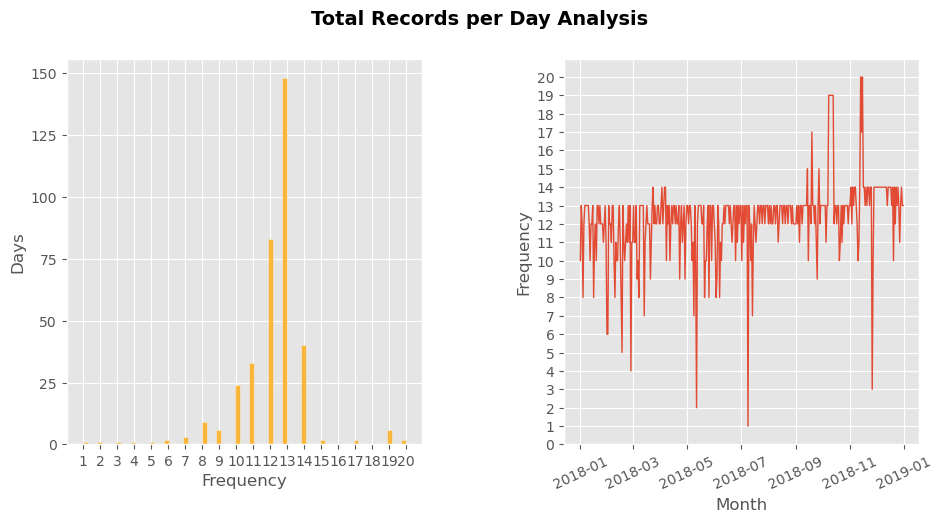

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))


#AXIS 1 Histogram
sns.histplot(data=df2, x='Freq',color="orange",ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Days')
ax[0].set_xticks(np.arange(1,21,1))
ax[0].set_yticks(np.arange(0,151,25))


#AXIS 2 Line Plot
sns.lineplot(x="Day", y="Freq", data=df2,ax=ax[1],linewidth=1)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Frequency')
ax[1].set_yticks(np.arange(0,21,1))
plt.xticks(rotation=25)

plt.subplots_adjust(wspace=0.4)
fig.suptitle('Total Records per Day Analysis', fontsize=14, fontweight='bold')
#plt.savefig('plots/aod_plot/merged_data_Record_per_day')
plt.show()

## Scaling Mean AOD 

### Function to plot bar for nan, positive and negative value

In [23]:
def plot_dataset_catergory_bars(ds_3DR, ds_3D, ds_merged,ROI_count):
    # Define figure and subplots
    fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
    
    color = [['#4DA6FF','#A6D8FF','#004C8C'],['#FFB27A','#FF7F00','#FF5800'],['#F9E79F','#FCF3CF','#B7950B']]
    # Loop over datasets and plot bar graphs
    for i, ds in enumerate([ds_3DR, ds_3D, ds_merged]):
        # Count NaN, positive, and negative values
        
        pos = np.sum(ds.AOD.data > 0)
        neg = np.sum(ds.AOD.data <= 0)
        count = ds.AOD.count().values

        t,m,n = ds.AOD.data.shape
        tot = ROI_count*t
        print(t,m,n,ROI_count)
        # Data dict
        Data = {'NaN':100 - np.round((count/tot)*100,2) , 'Positive': np.round((pos/tot)*100,2),'Negative':np.round((neg/tot)*100,2)}
        
        # Choosing color palette
        color_palette = color[i]
        
        # PLot
        bars = ax[i].bar(Data.keys(), Data.values(), color=color_palette,alpha=0.6)

        # Annotations
        for j, bar in enumerate(bars):
            ax[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{list(Data.values())[j]}%', ha='center')

        # Labels
        ax[i].set_ylabel('Total Data')
        legend_labels = ['NaN', 'Positive','Negative']
        ax[i].legend(bars, legend_labels,prop={'size': 7})

    # Title
    ax[0].set_title(f'3DR Data')
    ax[1].set_title(f'3D Data')
    ax[2].set_title(f'Modis Data')
        
    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.4)
    
    # Save figure
    #plt.savefig('plots/aod_plot/data_distribution')
    # Show plot
    plt.show()


# bar and line graph plots

In [24]:
ROI_count = ds_modis_mask.MASK.count().values
#plot_dataset_catergory_bars(ds3_3DR, ds3_3D, ds2_modis,ROI_count)

### Function to plot time series graph

In [28]:
def plot_aod_time_series(ds_3DR, ds_3D, ds_modis):
    
    # Function to resample the data according to time parameter
    t = ['1D','1M']
    titles = ['Daily','Montly']
    n,m = 2,2
    fig, ax = plt.subplots(nrows=n,ncols=m,figsize=(20,15) )
    
    for r in range(n):
        
        if t[r]:
            ds_3DR = ds_3DR.resample(time=t[r]).mean()
            ds_3D = ds_3D.resample(time=t[r]).mean()
            ds_modis = ds_modis.resample(time=t[r]).mean()
        
        c = 0
        
        ########## Mean Plot
        
        data1_mean = ds_3DR['AOD'].mean(dim=('latitude', 'longitude'))
        data2_mean = ds_3D['AOD'].mean(dim=('latitude', 'longitude'))
        data3_mean = ds_modis['AOD'].mean(dim=('latitude', 'longitude'))

        data1_mean.plot.line(ax=ax[r][c], label='3DR Data')
        data2_mean.plot.line(ax=ax[r][c], label='3D Data')
        data3_mean.plot.line(ax=ax[r][c], label='Modis Data')

        ax[r][c].legend()
        ax[r][c].set_xlabel('(Time)',weight='bold')
        ax[r][c].set_ylabel('(Mean AOD)',weight='bold')
        ax[r][c].set_title(f'Mean AOD {titles[r]}',weight='bold')

        ########## Count Plot
        
        data1_count = ds_3DR['AOD'].count(dim=('latitude', 'longitude'))
        data2_count = ds_3D['AOD'].count(dim=('latitude', 'longitude'))
        data3_count = ds_modis['AOD'].count(dim=('latitude', 'longitude'))

        data1_count.plot.line(ax=ax[r][c+1], label='3DR Data')
        data2_count.plot.line(ax=ax[r][c+1], label='3D Data')
        data3_count.plot.line(ax=ax[r][c+1], label='Modis Data')

        ax[r][c+1].legend()
        ax[r][c+1].set_xlabel('(Time)', weight='bold')
        ax[r][c+1].set_ylabel('(AOD Observation)',weight='bold')
        ax[r][c+1].set_title(f'Observed AOD {titles[r]}',weight='bold')
        fig.subplots_adjust(hspace=0.4)
        #plt.savefig('./plots/aod_plot/3D_3DR_merged_comparison.png')

plt.show()


In [30]:
ds2_modis['AOD'].count(dim=('latitude', 'longitude'))

<xarray.DataArray 'AOD' (time: 365)>
array([221, 224, 209, 234, 209, 231, 237, 254, 243, 228, 241, 206, 243,
       226, 249, 248, 240, 250, 242, 257, 239, 258, 230, 240, 251, 221,
       243, 225, 251, 236, 238, 252, 251, 257, 241, 174, 130, 126, 223,
       240, 172, 131, 201, 152, 244, 225, 258, 251, 244, 265, 247, 260,
       225, 234, 245, 252, 242, 237, 238, 204, 249, 215, 245, 244, 253,
       266, 235, 266, 224, 256, 239, 233, 244, 172, 189, 219, 247, 228,
       248, 236, 256, 260, 236, 260, 234, 250, 251, 259, 250, 235, 268,
       228, 248, 242, 236, 214, 228, 226, 208, 234, 199, 231, 236, 240,
       233, 214, 250, 223, 234, 202, 245, 244, 250, 263, 250, 254, 234,
       252, 231, 245, 244, 204, 219, 209, 243, 197, 229, 218, 232, 246,
       238, 260, 210, 225, 229, 249, 244, 209, 242, 214, 248, 219, 213,
       214, 207, 226, 204, 242, 195, 226, 197, 209, 192, 224, 238, 203,
       212, 157, 120, 114,  92, 143, 130, 169, 170, 189, 167, 151, 151,
       191, 219, 178, 149, 114, 117, 120,  56,  25,  12,  32,  43,  86,
        59,  32,  44,  79, 125, 123, 122,  86,  51,  42,  39,  21,  53,
        40,  24,  21,  26,  43,  39,  26,  14,  20,  36,  32,  20,  29,
        46,  67,  60,  64,  57,  86,  63,  74,  32,  41,  29,  14,  26,
        40,  39,  22,   7,  54,  64,  60,  38,  49,  58,  42,  39,  38,
        45,  35,  45,  44,  44,  59,  52,  75,  59,  49,  28,  59,  62,
        73,  84,  48, 105, 101, 138, 101, 176, 152, 191, 175, 188, 206,
       220, 206, 157, 101,  87, 144, 170, 191, 218, 192, 221, 199, 235,
       246, 216, 241, 211, 224, 230, 248, 240, 228, 210, 127, 194, 170,
       241, 225, 202, 227, 214, 247, 233, 267, 256, 265, 263, 249, 271,
       248, 252, 235, 247, 234, 221, 212, 189, 246, 199, 240, 245, 257,
       252, 251, 249, 217, 244, 231, 247, 230, 233, 230, 191, 245, 236,
       239, 225, 254, 260, 228, 226, 202, 240, 230, 241, 215, 220, 205,
       185, 231, 221, 242, 230, 226, 223, 215, 226, 222, 247, 194, 128,
       177, 220, 245, 233, 253, 229, 244, 249, 248, 241, 231, 247, 237,
       259])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31

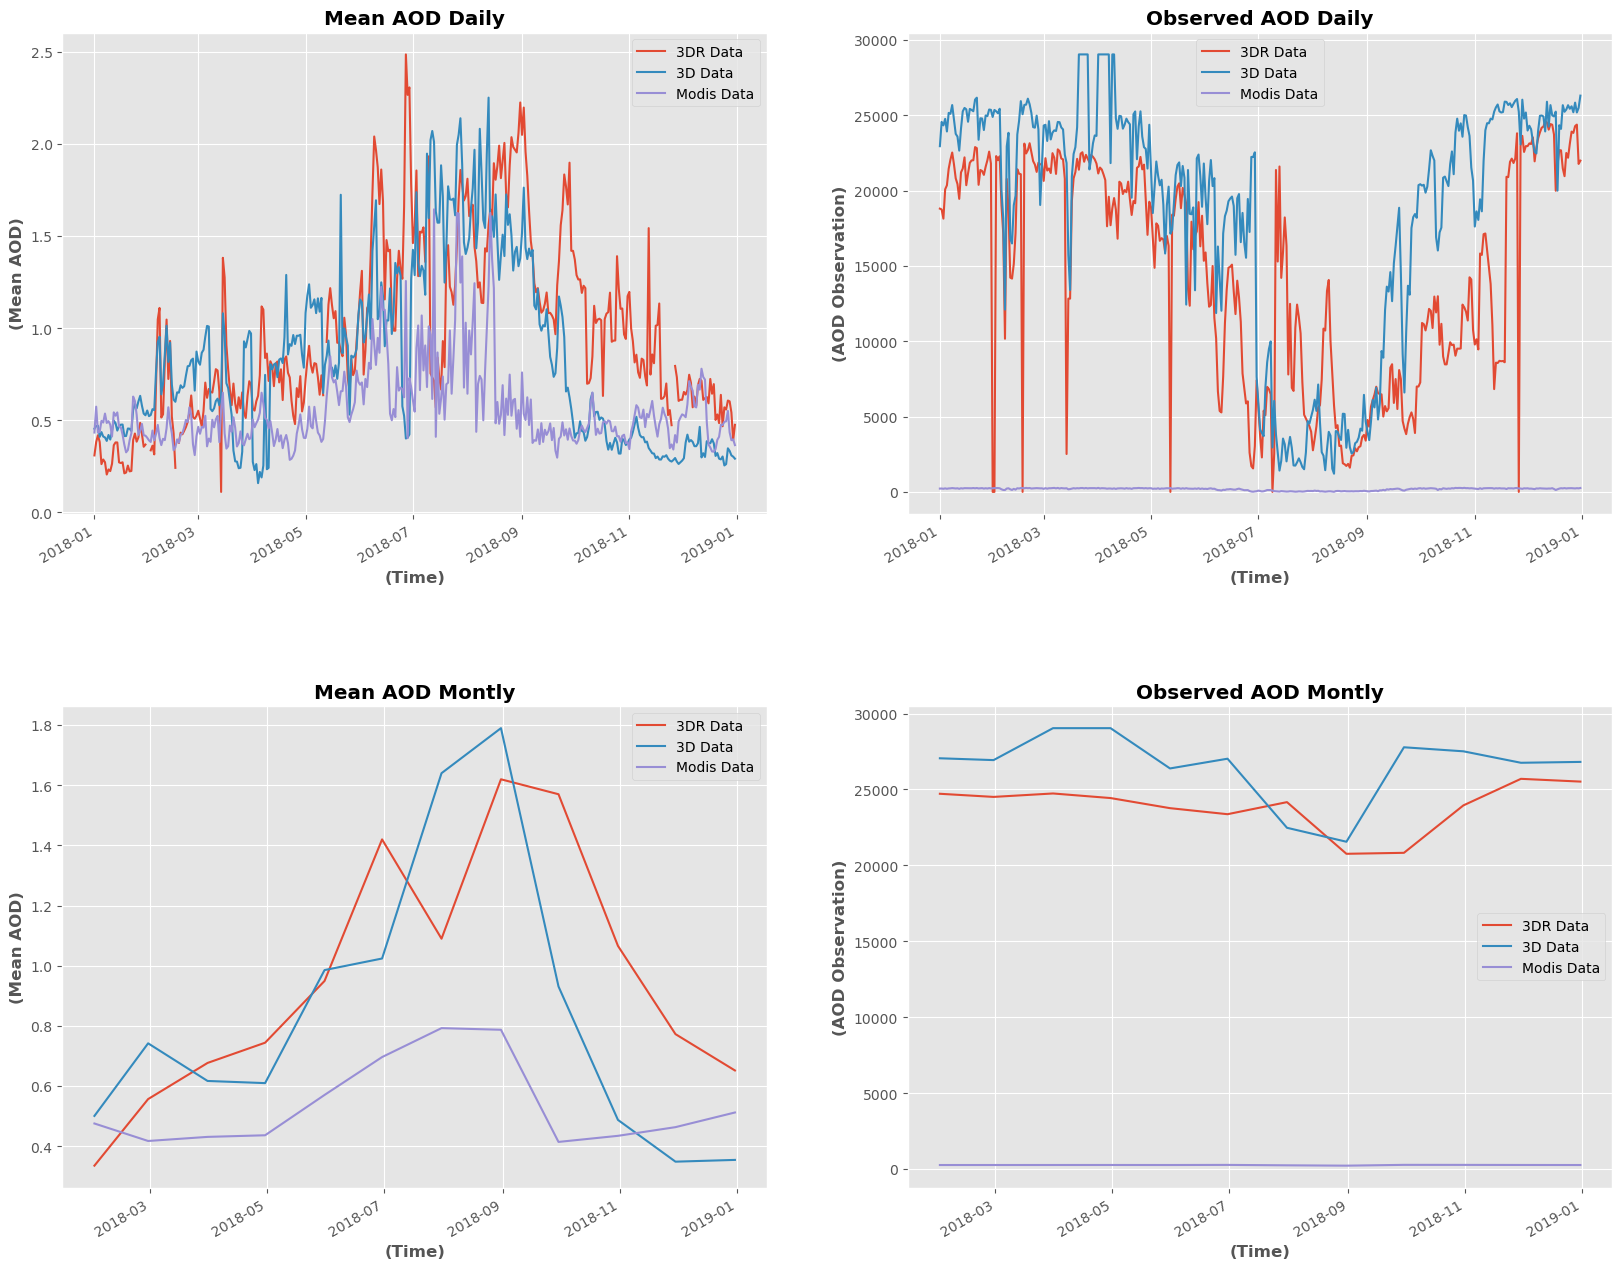

In [27]:
plot_aod_time_series(ds2_3DR, ds2_3D, ds_modis)
